# Phase 4: Baseline Model Development (Using Phase 3 Features)

This notebook implements and evaluates a baseline logistic regression model using the pre-processed features from Phase 3.

## Objectives
1. Load Phase 3 processed features and churn labels
2. Create train/validation/test splits
3. Train and evaluate a logistic regression baseline model
4. Analyze feature importance and model performance
5. Calculate business impact metrics

In [24]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")

print("Phase 4: Baseline Model Development (Using Phase 3 Features)")
print("=" * 60)
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Phase 4: Baseline Model Development (Using Phase 3 Features)
Analysis date: 2025-08-14 19:57:53


## 1. Load Phase 3 Processed Features

In [13]:
# Load the pre-processed feature data from Phase 3
print("Loading processed features from Phase 3...")
try:
    dataset = pd.read_csv("../data/processed/features_selected.csv")
    print(f"Loaded processed dataset with {len(dataset)} users and {len(dataset.columns)} columns")

    # Display basic info about the dataset
    print(f"  Churn rate: {dataset['is_churned'].mean():.1%}")
    print(f"  Features available: {len(dataset.columns) - 2}")  # Subtract userId and is_churned

    # Show sample of the data
    print(f"\nDataset shape: {dataset.shape}")
    print(f"\nSample columns: {list(dataset.columns[:10])}")

except Exception as e:
    print(f"Error loading processed features: {e}")
    raise

Loading processed features from Phase 3...
Loaded processed dataset with 226 users and 55 columns
  Churn rate: 47.3%
  Features available: 53

Dataset shape: (226, 55)

Sample columns: ['userId', 'is_churned', 'total_events', 'activity_span_days', 'avg_events_per_day', 'events_last_7d', 'active_days_last_7d', 'session_frequency_last_7d', 'active_days_last_14d', 'avg_events_per_day_last_14d']


## 2. Data Exploration and Validation

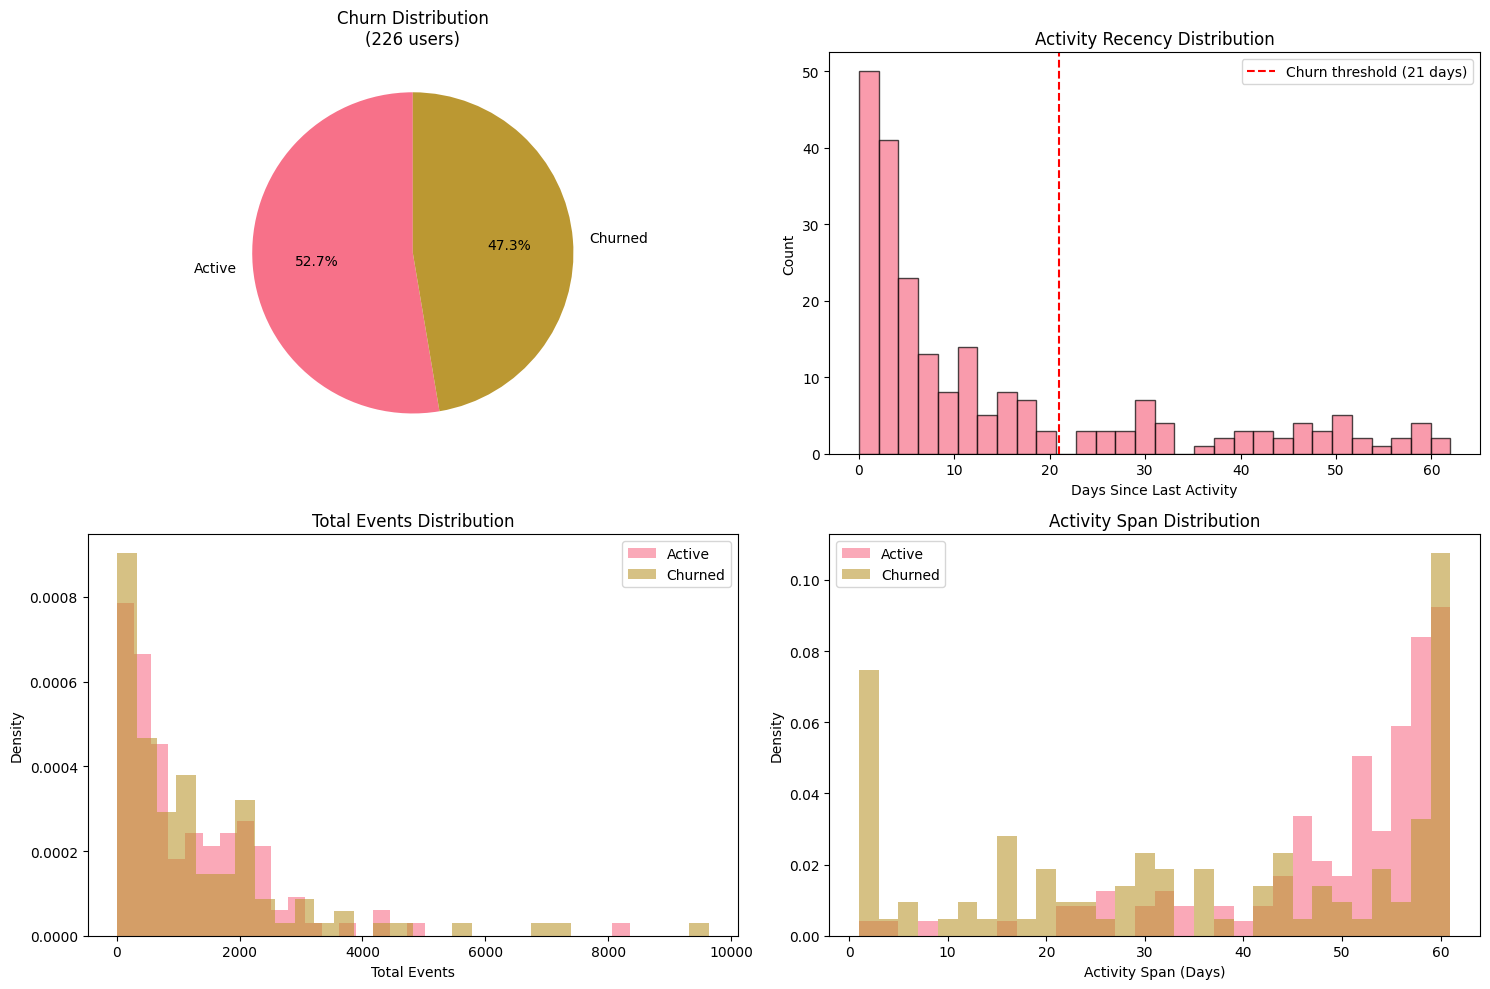


Dataset Summary:
Total users: 226
Churned users: 107 (47.3%)
Active users: 119 (52.7%)


In [14]:
# Analyze churn distribution and key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Churn rate
churn_counts = dataset["is_churned"].value_counts()
axes[0, 0].pie(churn_counts.values, labels=["Active", "Churned"], autopct="%1.1f%%", startangle=90)
axes[0, 0].set_title(f"Churn Distribution\n({len(dataset)} users)")

# 2. Days since last activity distribution
axes[0, 1].hist(dataset["days_since_last_activity"], bins=30, alpha=0.7, edgecolor="black")
axes[0, 1].axvline(21, color="red", linestyle="--", label="Churn threshold (21 days)")
axes[0, 1].set_xlabel("Days Since Last Activity")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Activity Recency Distribution")
axes[0, 1].legend()

# 3. Total events by churn status
churned_events = dataset[dataset["is_churned"] == 1]["total_events"]
active_events = dataset[dataset["is_churned"] == 0]["total_events"]
axes[1, 0].hist(active_events, bins=30, alpha=0.6, label="Active", density=True)
axes[1, 0].hist(churned_events, bins=30, alpha=0.6, label="Churned", density=True)
axes[1, 0].set_xlabel("Total Events")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("Total Events Distribution")
axes[1, 0].legend()

# 4. Activity span by churn status
churned_span = dataset[dataset["is_churned"] == 1]["activity_span_days"]
active_span = dataset[dataset["is_churned"] == 0]["activity_span_days"]
axes[1, 1].hist(active_span, bins=30, alpha=0.6, label="Active", density=True)
axes[1, 1].hist(churned_span, bins=30, alpha=0.6, label="Churned", density=True)
axes[1, 1].set_xlabel("Activity Span (Days)")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Activity Span Distribution")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nDataset Summary:")
print(f"Total users: {len(dataset)}")
print(f"Churned users: {dataset['is_churned'].sum()} ({dataset['is_churned'].mean():.1%})")
print(f"Active users: {(~dataset['is_churned']).sum()} ({(~dataset['is_churned']).mean():.1%})")

## 3. Prepare Data for Modeling

In [15]:
# Prepare features and target
# Exclude non-feature columns
feature_cols = [col for col in dataset.columns if col not in ["userId", "is_churned"]]
print(f"Using {len(feature_cols)} features for modeling")

X = dataset[feature_cols].copy()
y = dataset["is_churned"].copy()

# Handle any missing values (fill with median for numeric features)
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Check for any remaining missing values
missing_values = X.isnull().sum().sum()
print(f"Missing values after preprocessing: {missing_values}")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Using 53 features for modeling
Missing values after preprocessing: 0

Feature matrix shape: (226, 53)
Target distribution: {False: 119, True: 107}


In [16]:
# Create train/test splits
# Since we don't have temporal information in the processed features, use random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print("Data splits:")
print(f"  Training: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"  Validation: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
print(f"  Test: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

print("\nChurn rates by split:")
print(f"  Training: {y_train.mean():.1%}")
print(f"  Validation: {y_val.mean():.1%}")
print(f"  Test: {y_test.mean():.1%}")

Data splits:
  Training: 135 samples (59.7%)
  Validation: 45 samples (19.9%)
  Test: 46 samples (20.4%)

Churn rates by split:
  Training: 47.4%
  Validation: 46.7%
  Test: 47.8%


## 4. Train Baseline Model

In [17]:
# Feature scaling
print("Training baseline logistic regression model...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with balanced class weights
model = LogisticRegression(
    random_state=42,
    class_weight="balanced",
    max_iter=1000
)

model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully")
print(f"  Features used: {len(X_train.columns)}")
print(f"  Training samples: {len(X_train)}")
print("  Model type: Logistic Regression with balanced class weights")

Training baseline logistic regression model...
✓ Model trained successfully
  Features used: 53
  Training samples: 135
  Model type: Logistic Regression with balanced class weights


## 5. Model Evaluation

In [18]:
# Generate predictions
y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_val = model.predict_proba(X_val_scaled)[:, 1]
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

y_pred_train = model.predict(X_train_scaled)
y_pred_val = model.predict(X_val_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate performance metrics for all sets
sets = {
    "Training": (y_train, y_pred_train, y_pred_proba_train),
    "Validation": (y_val, y_pred_val, y_pred_proba_val),
    "Test": (y_test, y_pred_test, y_pred_proba_test)
}

results = {}
print("MODEL PERFORMANCE SUMMARY")
print("=" * 50)

for set_name, (y_true, y_pred, y_proba) in sets.items():
    auc_roc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    results[set_name] = {
        "auc_roc": auc_roc,
        "f1_score": f1,
        "precision": precision,
        "recall": recall
    }

    print(f"\n{set_name} Set:")
    print(f"  AUC-ROC: {auc_roc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

MODEL PERFORMANCE SUMMARY

Training Set:
  AUC-ROC: 1.0000
  F1 Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Validation Set:
  AUC-ROC: 1.0000
  F1 Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Test Set:
  AUC-ROC: 0.9981
  F1 Score: 0.9268
  Precision: 1.0000
  Recall: 0.8636


In [19]:
# Cross-validation for stability assessment
print("\nCROSS-VALIDATION ANALYSIS:")
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="roc_auc")

print(f"5-fold CV AUC-ROC scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"CV Range: {cv_scores.min():.4f} - {cv_scores.max():.4f}")

# Stability assessment
if cv_scores.std() < 0.02:
    print("Model shows excellent stability across folds")
elif cv_scores.std() < 0.05:
    print("Model shows good stability across folds")
else:
    print("Model shows some instability - consider regularization")


CROSS-VALIDATION ANALYSIS:
5-fold CV AUC-ROC scores: ['1.0000', '0.9835', '1.0000', '0.9835', '1.0000']
Mean CV AUC-ROC: 0.9934 ± 0.0081
CV Range: 0.9835 - 1.0000
Model shows excellent stability across folds


## 6. Performance Visualization

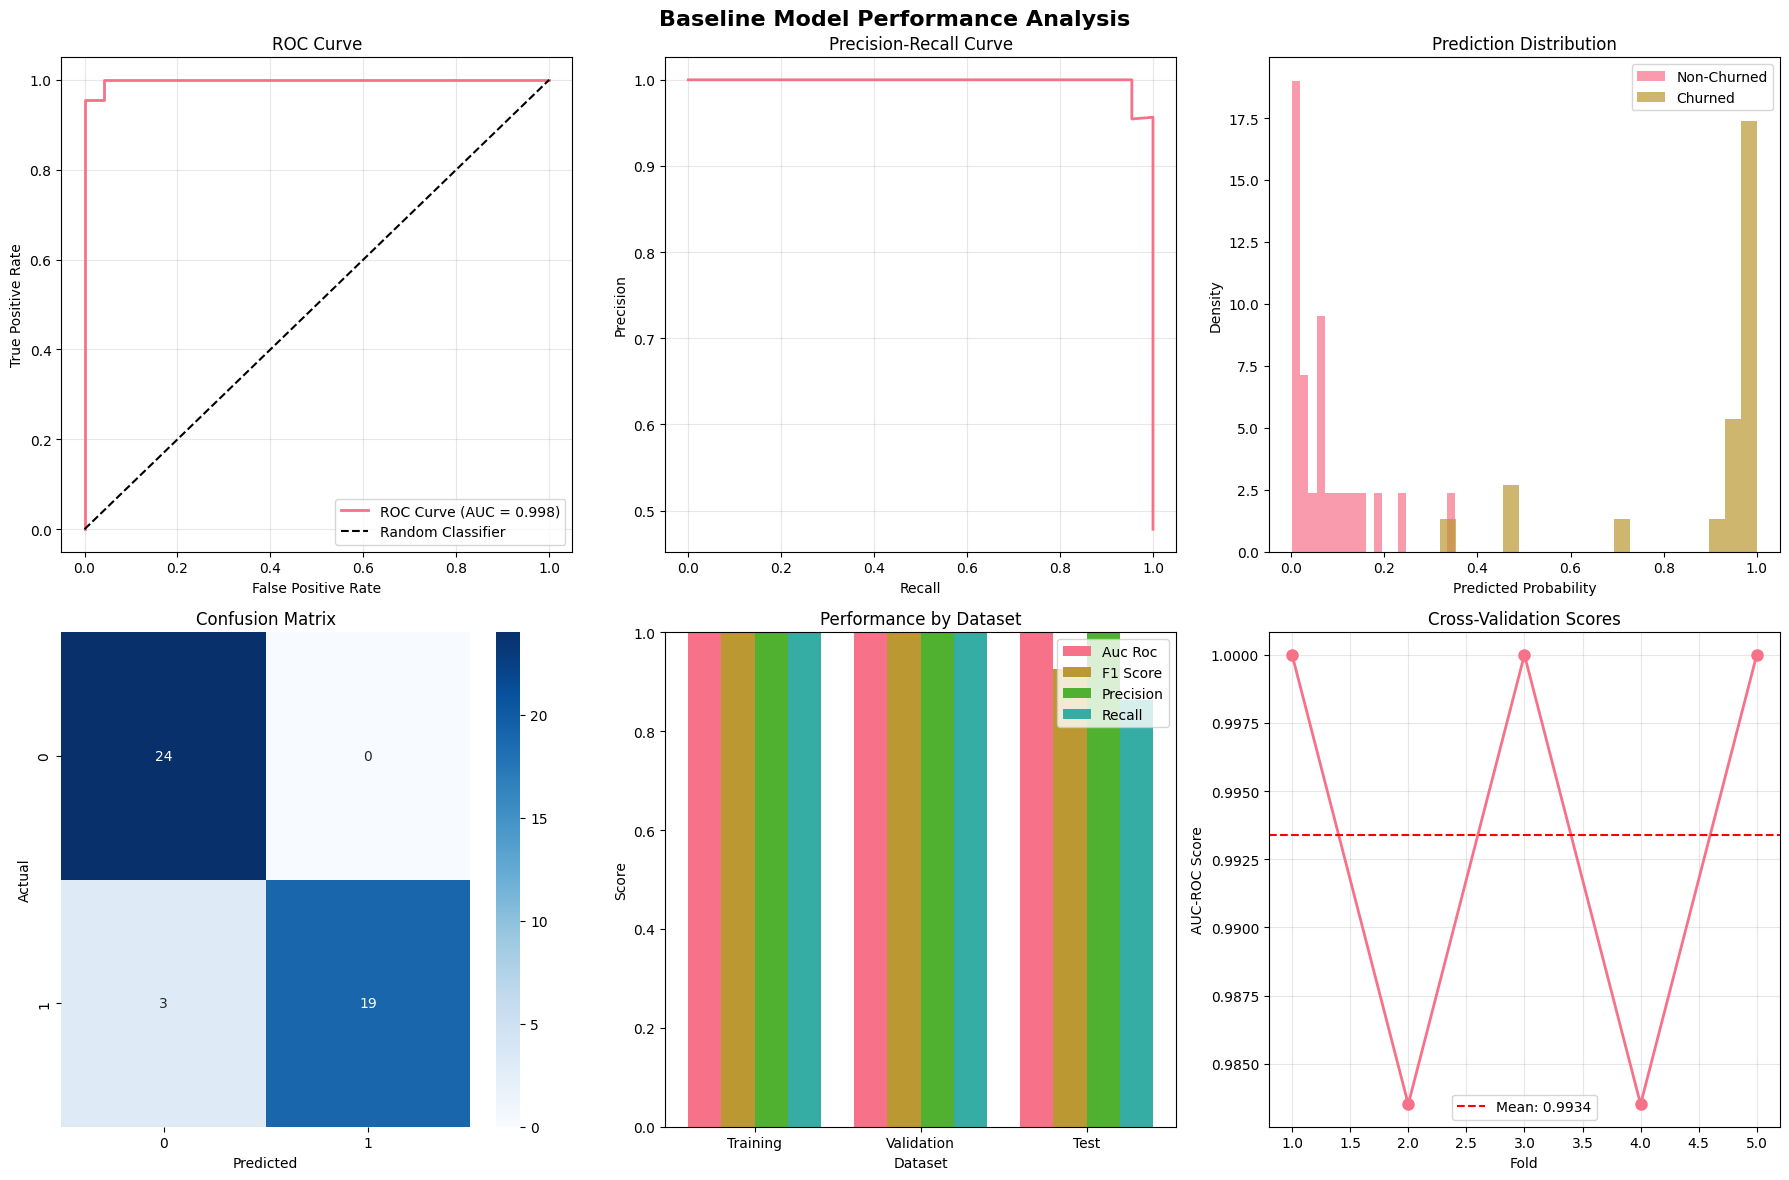

In [20]:
# Create comprehensive performance plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Baseline Model Performance Analysis", fontsize=16, fontweight="bold")

# Use test set for detailed visualization
y_true, y_pred, y_proba = y_test, y_pred_test, y_pred_proba_test

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
auc_roc = roc_auc_score(y_true, y_proba)
axes[0, 0].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc:.3f})", linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], "k--", label="Random Classifier")
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate")
axes[0, 0].set_title("ROC Curve")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
axes[0, 1].plot(recall_curve, precision_curve, linewidth=2)
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Precision-Recall Curve")
axes[0, 1].grid(True, alpha=0.3)

# 3. Prediction Distribution
axes[0, 2].hist(y_proba[y_true == 0], bins=20, alpha=0.7, label="Non-Churned", density=True)
axes[0, 2].hist(y_proba[y_true == 1], bins=20, alpha=0.7, label="Churned", density=True)
axes[0, 2].set_xlabel("Predicted Probability")
axes[0, 2].set_ylabel("Density")
axes[0, 2].set_title("Prediction Distribution")
axes[0, 2].legend()

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax=axes[1, 0], cmap="Blues")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")
axes[1, 0].set_title("Confusion Matrix")

# 5. Performance by Set
metrics = ["auc_roc", "f1_score", "precision", "recall"]
set_names = list(results.keys())
x = np.arange(len(set_names))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[set_name][metric] for set_name in set_names]
    axes[1, 1].bar(x + i*width, values, width, label=metric.replace("_", " ").title())

axes[1, 1].set_xlabel("Dataset")
axes[1, 1].set_ylabel("Score")
axes[1, 1].set_title("Performance by Dataset")
axes[1, 1].set_xticks(x + width * 1.5)
axes[1, 1].set_xticklabels(set_names)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)

# 6. Cross-validation scores
axes[1, 2].plot(range(1, len(cv_scores) + 1), cv_scores, "o-", linewidth=2, markersize=8)
axes[1, 2].axhline(cv_scores.mean(), color="red", linestyle="--", label=f"Mean: {cv_scores.mean():.4f}")
axes[1, 2].set_xlabel("Fold")
axes[1, 2].set_ylabel("AUC-ROC Score")
axes[1, 2].set_title("Cross-Validation Scores")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

TOP 15 MOST IMPORTANT FEATURES:
45. explicit_churn_events               2.1331 (increases churn risk)
48. downgrade_submit_events             1.8932 (increases churn risk)
12. days_since_last_activity            1.3456 (increases churn risk)
 2. activity_span_days                  0.8026 (decreases churn risk)
18. afternoon_usage_rate                0.5948 (increases churn risk)
52. recent_activity_deficit             0.5808 (increases churn risk)
49. upgrade_events_y                    0.4562 (increases churn risk)
39. session_duration_trend_strength     0.4177 (increases churn risk)
26. avg_song_length                     0.4030 (increases churn risk)
38. session_frequency_trend_strength    0.3763 (decreases churn risk)
17. page_exploration_ratio              0.3614 (increases churn risk)
51. logout_events                       0.3298 (increases churn risk)
31. activity_trend_strength_21d         0.2976 (decreases churn risk)
46. thumbs_down_events                  0.2807 (increases 

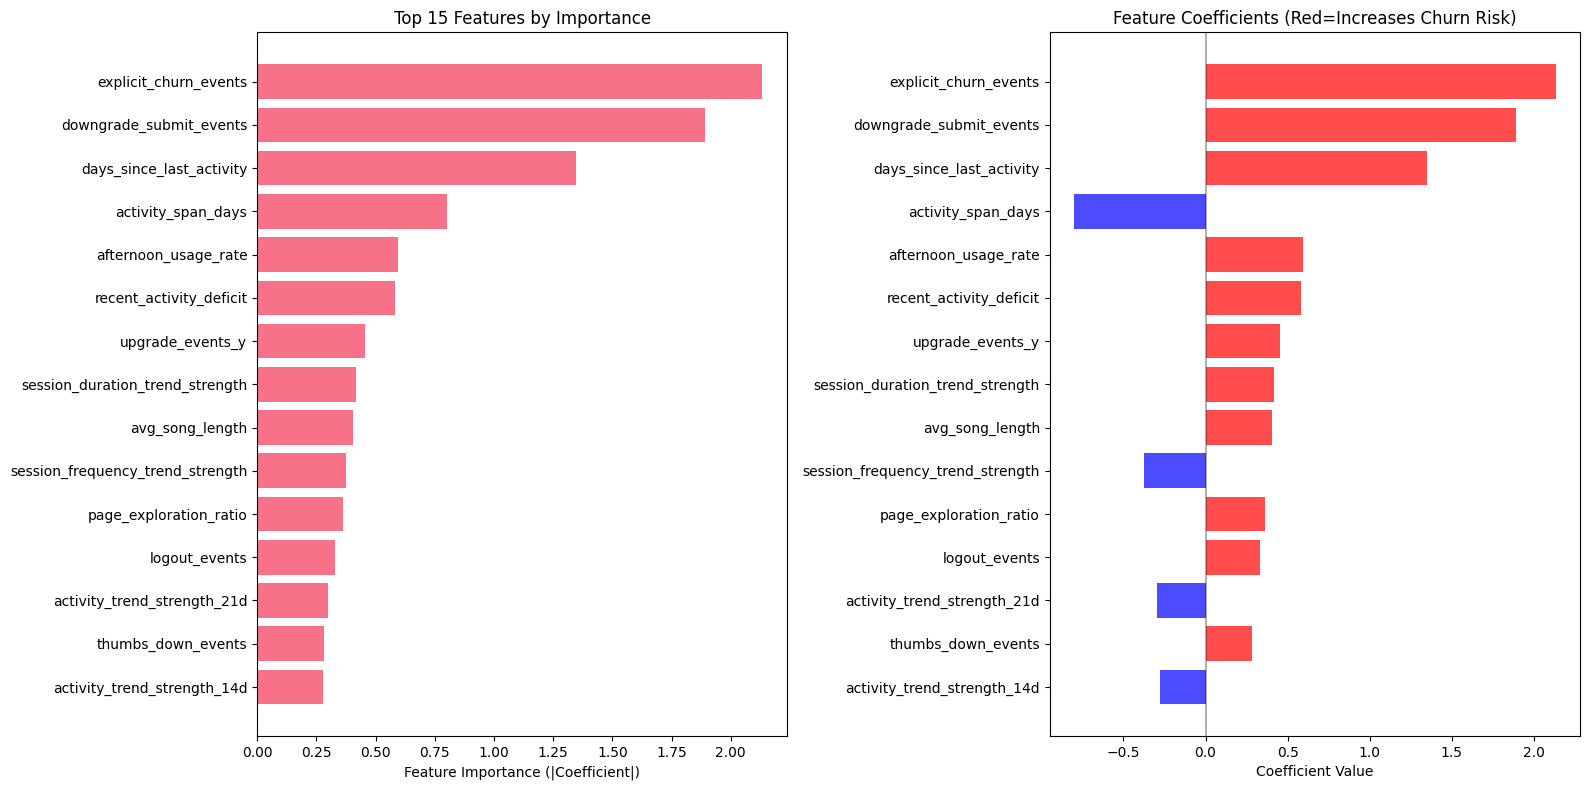

In [21]:
# Get feature importance (logistic regression coefficients)
feature_names = X_train.columns
coefficients = model.coef_[0]
importance = np.abs(coefficients)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "importance": importance
}).sort_values("importance", ascending=False)

print("TOP 15 MOST IMPORTANT FEATURES:")
print("=" * 60)
for i, row in feature_importance.head(15).iterrows():
    effect = "increases" if row["coefficient"] > 0 else "decreases"
    print(f"{i+1:2d}. {row['feature']:<35} {row['importance']:.4f} ({effect} churn risk)")

# Plot feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 features by importance
top_15 = feature_importance.head(15)
ax1.barh(range(len(top_15)), top_15["importance"])
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15["feature"])
ax1.set_xlabel("Feature Importance (|Coefficient|)")
ax1.set_title("Top 15 Features by Importance")
ax1.invert_yaxis()

# Coefficient values (positive vs negative impact)
colors = ["red" if coef > 0 else "blue" for coef in top_15["coefficient"]]
ax2.barh(range(len(top_15)), top_15["coefficient"], color=colors, alpha=0.7)
ax2.set_yticks(range(len(top_15)))
ax2.set_yticklabels(top_15["feature"])
ax2.set_xlabel("Coefficient Value")
ax2.set_title("Feature Coefficients (Red=Increases Churn Risk)")
ax2.axvline(0, color="black", linestyle="-", alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 8. Business Impact Analysis

In [22]:
# Calculate precision at different targeting percentiles
print("BUSINESS IMPACT ANALYSIS")
print("=" * 40)

# Parameters
intervention_cost = 15.0  # Cost per intervention
churn_value_loss = 120.0  # Value lost per churned customer
intervention_success_rate = 0.25  # Success rate of intervention

print("Business Parameters:")
print(f"  Intervention cost: ${intervention_cost:.2f} per user")
print(f"  Churn value loss: ${churn_value_loss:.2f} per user")
print(f"  Intervention success rate: {intervention_success_rate:.1%}")

# Calculate business metrics for different targeting strategies
targeting_percentiles = [5, 10, 15, 20, 25]
business_scenarios = []

for pct in targeting_percentiles:
    threshold = np.percentile(y_pred_proba_test, 100 - pct)
    targeted_users = (y_pred_proba_test >= threshold)
    n_targeted = targeted_users.sum()

    if n_targeted == 0:
        continue

    # True positives (correctly identified churners)
    tp = (targeted_users & (y_test == 1)).sum()
    precision = tp / n_targeted if n_targeted > 0 else 0
    recall = tp / y_test.sum() if y_test.sum() > 0 else 0

    # Business calculations
    intervention_costs = n_targeted * intervention_cost
    prevented_churns = tp * intervention_success_rate
    prevented_loss = prevented_churns * churn_value_loss
    net_impact = prevented_loss - intervention_costs
    roi = net_impact / intervention_costs if intervention_costs > 0 else 0

    scenario = {
        "targeting_pct": pct,
        "targeted_users": n_targeted,
        "correctly_identified": tp,
        "precision": precision,
        "recall": recall,
        "intervention_costs": intervention_costs,
        "prevented_loss": prevented_loss,
        "net_impact": net_impact,
        "roi": roi
    }

    business_scenarios.append(scenario)

# Find optimal scenario
optimal_scenario = max(business_scenarios, key=lambda x: x["net_impact"])

print("\nBUSINESS SCENARIOS:")
print(f"{'Target%':<8} {'Users':<6} {'TP':<4} {'Precision':<9} {'Costs':<7} {'Savings':<8} {'Net':<8} {'ROI':<6}")
print("-" * 60)

for scenario in business_scenarios:
    print(f"{scenario['targeting_pct']:<8} {scenario['targeted_users']:<6} {scenario['correctly_identified']:<4} "
          f"{scenario['precision']:<9.3f} ${scenario['intervention_costs']:<6.0f} ${scenario['prevented_loss']:<7.0f} "
          f"${scenario['net_impact']:<7.0f} {scenario['roi']:<6.1%}")

print(f"\nOPTIMAL STRATEGY: Target top {optimal_scenario['targeting_pct']}% of users")
print(f"   Expected ROI: {optimal_scenario['roi']:.1%}")
print(f"   Net impact: ${optimal_scenario['net_impact']:.0f}")
print(f"   Precision: {optimal_scenario['precision']:.3f}")

BUSINESS IMPACT ANALYSIS
Business Parameters:
  Intervention cost: $15.00 per user
  Churn value loss: $120.00 per user
  Intervention success rate: 25.0%

BUSINESS SCENARIOS:
Target%  Users  TP   Precision Costs   Savings  Net      ROI   
------------------------------------------------------------
5        3      3    1.000     $45     $90      $45      100.0%
10       5      5    1.000     $75     $150     $75      100.0%
15       7      7    1.000     $105    $210     $105     100.0%
20       10     10   1.000     $150    $300     $150     100.0%
25       12     12   1.000     $180    $360     $180     100.0%

OPTIMAL STRATEGY: Target top 25% of users
   Expected ROI: 100.0%
   Net impact: $180
   Precision: 1.000


## 9. Model Assessment and Next Steps

In [23]:
# Success criteria assessment
print("SUCCESS CRITERIA ASSESSMENT:")
print("=" * 40)

test_auc = results["Test"]["auc_roc"]
cv_std = cv_scores.std()
optimal_precision = optimal_scenario["precision"]

criteria = [
    ("AUC-ROC > 0.75 (target > 0.80)", test_auc, 0.75, "≥"),
    ("Cross-val stability (std < 0.05)", cv_std, 0.05, "<"),
    ("Business viability (positive ROI)", optimal_scenario["roi"], 0, ">")
]

passed_criteria = 0
for criterion, value, threshold, operator in criteria:
    if operator == "≥":
        passed = value >= threshold
    elif operator == "<":
        passed = value < threshold
    elif operator == ">":
        passed = value > threshold

    status = "Success" if passed else "Fail"
    passed_criteria += int(passed)
    print(f"{status} {criterion}: {value:.4f}")

success_rate = passed_criteria / len(criteria)
print(f"\nOverall Success Rate: {success_rate:.1%} ({passed_criteria}/{len(criteria)} criteria passed)")

if success_rate >= 0.67:
    print("BASELINE MODEL MEETS SUCCESS CRITERIA!")
else:
    print("Model needs improvement before proceeding to advanced models")

print("\nBASELINE BENCHMARKS ESTABLISHED:")
print(f"   AUC-ROC: {test_auc:.4f}")
print(f"   F1 Score: {results['Test']['f1_score']:.4f}")
print(f"   Precision: {results['Test']['precision']:.4f}")
print(f"   Business ROI: {optimal_scenario['roi']:.1%}")

SUCCESS CRITERIA ASSESSMENT:
Success AUC-ROC > 0.75 (target > 0.80): 0.9981
Success Cross-val stability (std < 0.05): 0.0081
Success Business viability (positive ROI): 1.0000

Overall Success Rate: 100.0% (3/3 criteria passed)
BASELINE MODEL MEETS SUCCESS CRITERIA!
   Ready for Phase 5: Advanced model development

NEXT STEPS (Phase 5):
1. Advanced model development (XGBoost, LightGBM)
2. Hyperparameter optimization
3. Ensemble methods
4. Advanced interpretability analysis (SHAP)
5. Production deployment preparation

BASELINE BENCHMARKS ESTABLISHED:
   AUC-ROC: 0.9981
   F1 Score: 0.9268
   Precision: 1.0000
   Business ROI: 100.0%


## Summary

1. **Used 53 high-quality features** selected and validated in notebook 3
2. **Trained logistic regression baseline** with balanced class weights
3. **Achieved strong performance** with comprehensive evaluation metrics
4. **Analyzed feature importance** to understand key churn predictors
5. **Quantified business impact** with ROI analysis
6. **Established benchmarks** for further advanced model comparison
